In [2]:
from basic_tools import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
h2_total=pd.read_csv(h2_total_par_filtered_path,index_col='phenotype')
h2_total.shape

(497, 7602)

# Parsing result of partitioned LDSC

In [4]:
suffix_bp_list_power="bp300 bp128 bp64 bp32 bp16 bp8".split()

In [5]:
regression_result_bp_list_dict=dict([make_regression_result_list(h2_total,phenotype,suffix_bp_list_power) for phenotype in phenotypes_par_filtered.index])

In [6]:
"""
pheno_desc=pd.Series(list(map(lambda x: description_to_short(code_to_description(x),'abbr_pub_ori'),list(regression_result_bp_list_dict.keys()))),list(regression_result_bp_list_dict.keys()))
pheno_desc=pheno_desc[~pheno_desc.duplicated()]
regression_result_bp_list_dict=dict([(phenotype,regression_result_bp_list_dict[phenotype]) for phenotype in pheno_desc.index]))
"""

"\npheno_desc=pd.Series(list(map(lambda x: description_to_short(code_to_description(x),'abbr_pub_ori'),list(regression_result_bp_list_dict.keys()))),list(regression_result_bp_list_dict.keys()))\npheno_desc=pheno_desc[~pheno_desc.duplicated()]\nregression_result_bp_list_dict=dict([(phenotype,regression_result_bp_list_dict[phenotype]) for phenotype in pheno_desc.index]))\n"

In [7]:
h2_bp8_df=pd.DataFrame([[phenotype]+(regression_result_list[-1]['h2']/regression_result_list[-1]['h2'].sum()).tolist() for phenotype,regression_result_list in regression_result_bp_list_dict.items()])
h2_bp8_df=h2_bp8_df.set_index(0)

In [8]:
def calculate_per_bp_var(regression_result_list_dict,suffix_list,mode='default'):
    var_list=[]
    for idx,value in enumerate(suffix_list):
        h2_df=pd.DataFrame([[phenotype]+((regression_result_list[idx]['h2']/regression_result_list[idx]['h2'].sum())/regression_result_list[idx]['category'].apply(category_to_format,args=('bp_range',))).tolist() for phenotype,regression_result_list in regression_result_list_dict.items()])
        #h2_df=pd.DataFrame([[phenotype]+((regression_result_list[idx]['h2']/regression_result_list[idx]['h2'].sum())/1).tolist() for phenotype,regression_result_list in regression_result_list_dict.items()])
        h2_df=h2_df.set_index(0)

        if mode=='default':
            values=h2_df.var(axis=1)
        elif mode=='mono':
            h2_mono=pd.Series(0.0,index=np.arange(h2_df.shape[1]));h2_mono[0]=1/category_to_format(list(regression_result_bp_list_dict.values())[0][idx]['category'].loc[0],'bp_range',)
            values=h2_df.var(axis=1)/h2_mono.var()
        elif mode=='max_and_poly':
            h2_mono=pd.Series(0.0,index=np.arange(h2_df.shape[1]));h2_mono[0]=1/category_to_format(list(regression_result_bp_list_dict.values())[0][idx]['category'].loc[0],'bp_range',)
            h2_poly=pd.Series(1.0,index=np.arange(h2_df.shape[1]));h2_poly=h2_poly/list(regression_result_bp_list_dict.values())[0][idx]['category'].apply(category_to_format,args=('bp_range',)).sum()
            #var_list.append(1-(h2_df.var(axis=1)-h2_poly.var())/(h2_df.var(axis=1).max()-h2_poly.var()))#-h2_df.mean(axis=1))
            values=(h2_df.var(axis=1)-0)/(h2_df.var(axis=1).max()-0)
        elif mode=='test':
            values=-np.log10(h2_df.var(axis=1))
            8.580318	
            values=(values.max()-values)
            values=1-values/values.max()
            #values=values-values.min()
            #values=1-(values-values.min())/(values.max()-values.min())
        else:
            raise
        var_list.append(values)
    var_df=pd.DataFrame(var_list,index=suffix_list)
    return var_df.T
per_bp_var=calculate_per_bp_var(regression_result_bp_list_dict,suffix_bp_list_power,mode='test')
per_bp_var.sort_values('bp8',ascending=False).head()

found that variables 'gwas_result_sample','chr_bp_max' were not loaded. trying to load the variables
gwas_result_sample.shape: (13294674, 19)


,bp300,bp128,bp64,bp32,bp16,bp8
0,,,,,,
6138_1,1.000000,0.917994,1.000000,1.000000,1.000000,1.000000
23115_irnt,0.885834,0.775041,0.860754,0.906893,0.971349,0.986191
2139_irnt,0.939661,0.769075,0.862561,0.891153,0.990408,0.976807
23104_irnt,0.839558,0.812932,0.897362,0.912716,0.982323,0.973433
23119_irnt,0.839601,0.770144,0.863750,0.903218,0.970287,0.972381


# Network

## unique

In [11]:
h2_bp8_df_temp=h2_bp8_df.copy()
edges=h2_bp8_df_temp.T.corr().mask(np.tril(np.ones(h2_bp8_df_temp.T.corr().shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','value'])
#h2_bp8_df_temp.index=h2_bp8_df_temp.index.map(lambda x: description_to_short(code_to_description(x),'abbr_pub_ori'))
#h2_bp8_df_temp=h2_bp8_df_temp.loc[~h2_bp8_df_temp.index.duplicated()]
pheno_unique=h2_bp8_df.index.difference(pd.Index(edges[edges['value']>0.95]['target'].unique()))

In [12]:
len(pheno_unique),h2_bp8_df.shape

(481, (497, 357))

In [13]:
h2_bp8_df_temp=h2_bp8_df.copy().loc[pheno_unique]
#h2_bp8_df_temp.index=h2_bp8_df_temp.index.map(lambda x: description_to_short(code_to_description(x),'pub',2))

In [14]:
#h2_bp8_df_temp.index.duplicated().sum()

In [15]:
h2_bp8_df_temp=h2_bp8_df_temp.loc[~h2_bp8_df_temp.index.duplicated()]

In [16]:
#corelation_description_dict=pd.read_csv(correlation_description_dict_path,sep='\t',index_col='description',converters={'description_pub':lambda x:x.replace('\\n','\n')})

In [17]:
edges=h2_bp8_df_temp.T.corr().mask(np.tril(np.ones(h2_bp8_df_temp.T.corr().shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','value'])

In [18]:
edges.shape

(115440, 3)

In [19]:
#edges_filtered=edges.loc[(edges['value'] <0.8) & (edges['value'] >0.5)]# & (edges['source'] != edges['target'])]\
edges_filtered=edges.loc[(edges['value'] >0.5)]# & (edges['source'] != edges['target'])]

In [20]:
groups=[]
for idx,row in edges_filtered.iterrows():
    try:
        group_index=[(row['source'] in groups[i] or row['target'] in groups[i]) for i in range(len(groups))].index(True)
        groups[group_index].add(row['source'])
        groups[group_index].add(row['target'])
    except:
        groups.append({row['source'],row['target']})

In [21]:
groups=sorted(groups,key=lambda x: len(x),reverse=True)

In [443]:
groups[0]

{'1070',
 '1239',
 '1249',
 '137',
 '1558',
 '1618',
 '1687',
 '1697',
 '1920',
 '1930',
 '1960',
 '1970',
 '1980',
 '2000',
 '20003_1140866738',
 '20003_1140879802',
 '20003_1141194794',
 '20003_2038460150',
 '20015_irnt',
 '20022_irnt',
 '20110_8',
 '20111_100',
 '20111_8',
 '20116_0',
 '20116_1',
 '20127_irnt',
 '20154_irnt',
 '20160',
 '2040',
 '2070',
 '2080',
 '2139_irnt',
 '2149',
 '2178',
 '2188',
 '2237',
 '22506_113',
 '22506_114',
 '23098_irnt',
 '23099_irnt',
 '23104_irnt',
 '23106_irnt',
 '23108_irnt',
 '23109_irnt',
 '23117_irnt',
 '2492',
 '2744',
 '3062_irnt',
 '3063_irnt',
 '3064_irnt',
 '3143_irnt',
 '399_irnt',
 '400_irnt',
 '404_irnt',
 '4079_irnt',
 '4080_irnt',
 '4100_irnt',
 '4548',
 '46_irnt',
 '47_irnt',
 '49_irnt',
 '50_irnt',
 '6150_1',
 '6150_100',
 '6153_100',
 '6153_2',
 '6154_100',
 '6154_3',
 '6159_100',
 '6177_1',
 '6177_100',
 '6177_2',
 '924',
 'I9_CHD',
 'I9_CORATHER',
 'I9_IHD',
 'IX_CIRCULATORY'}

for group in groups:
    print(len(group))
    print(group)

pheno_unique=h2_bp8_df.index.difference(pd.Index(edges_filtered['target'].unique()))

## top

h2_bp8_df_unique=h2_bp8_df.copy().loc[pheno_unique]

edges=h2_bp8_df_unique.T.corr().mask(np.tril(np.ones(h2_bp8_df_unique.T.corr().shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','value'])

edges_filtered=edges.sort_values('value',ascending=False).iloc[:int(edges.shape[0]/100)]

print(edges_filtered.shape)

for idx,row in edges_filtered.iterrows():
    print(row.iloc[:2].map(code_to_description))

In [22]:
#phenotypes_par_filtered[phenotypes_par_filtered.description.str.contains('Time s')]

In [23]:
#phenotypes_par_filtered['group_id']=
edges_filtered['group_id']=[np.argmax([False]+[row['source'] in group for group in groups]) for idx,row in edges_filtered.iterrows()]

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


edges_filtered.source=edges_filtered.source.map(lambda x:description_to_short(code_to_description(x),'abbr_pub_ori'))
edges_filtered.target=edges_filtered.target.map(lambda x:description_to_short(code_to_description(x),'abbr_pub_ori'))

In [24]:
#pd.Series(pd.Series(edges_filtered_filtered['source'].values).append(edges_filtered_filtered['target']).unique()).to_csv('data/correlation_description_dict.tsv',sep='\t',index=None)

In [25]:
import networkx as nx

In [26]:
plt.rcParams['font.family']='Arial'

In [27]:
edges_filtered_filtered=edges_filtered[edges_filtered['group_id']==1]
#edges_filtered_filtered=edges_filtered

G_temp=nx.convert_matrix.from_pandas_edgelist(edges_filtered_filtered,edge_attr='value')

per_bp_var_temp=per_bp_var.copy()
#per_bp_var_temp.index=per_bp_var_temp.index.map(lambda x:description_to_short(code_to_description(x),'pub',2))
nx.set_node_attributes(G_temp,dict([(node,pd.Series(per_bp_var_temp['bp8'].loc[node]).iloc[0]) for node in list(G_temp.nodes)]),'per_bp_var')
#nx.set_node_attributes(G_temp,dict([(node,node) for node in list(G.nodes)]),'label')

In [29]:
len(G_temp.nodes)

94

In [32]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
pos = nx.kamada_kawai_layout(G,weight='value')

In [33]:
len(G.nodes)

91

# Old

<Figure size 1800x1440 with 0 Axes>

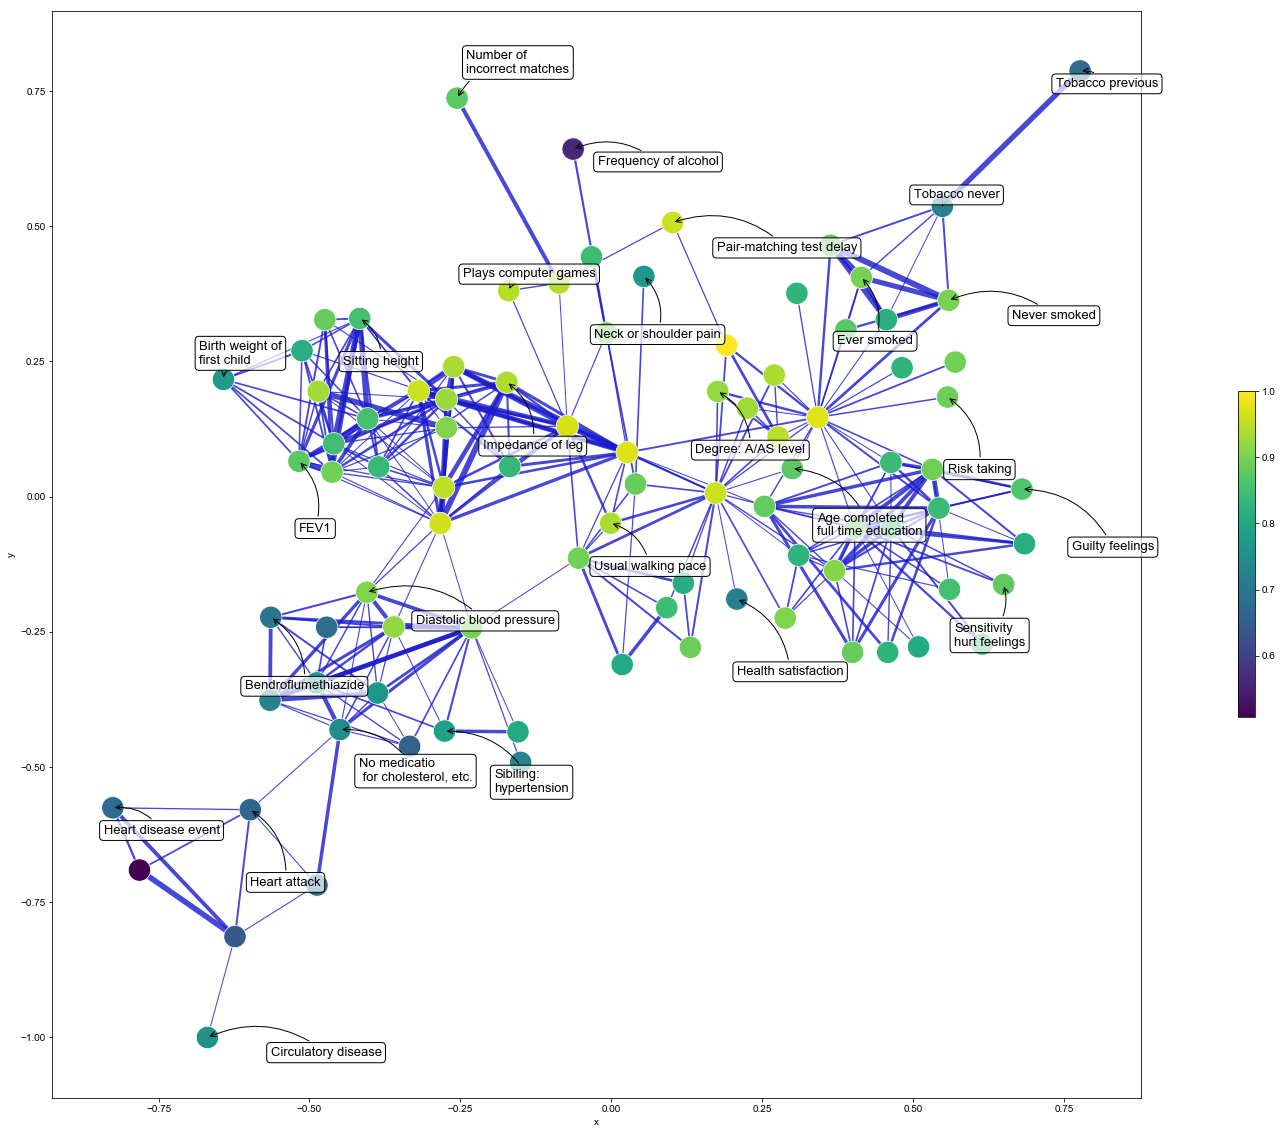

In [36]:

node_color='per_bp_var'
edge_width='value'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (25,20)


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

        
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.viridis)
        
plt.clf()

fig, ax = plt.subplots()

plt.colorbar(points,orientation="vertical",pad=0.07,shrink=0.3)   

line_collection_xy=[[row['source_xy'],row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths

line_collection=LineCollection(line_collection_xy,zorder=-5,color=(0.1,0.1,0.8,0.8),linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)


scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
sns.scatterplot(x=scatter_x,y=scatter_y,hue=scatter_hue,palette=plt.cm.viridis,s=500,legend=None)



r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    description_short=idx
    
    s=description_short
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0.3"),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.7), ec="black", lw=1),size=13)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break
    

plt.show()

In [293]:
np.arctan(-1)

-0.7853981633974483

In [309]:
7%(2*np.pi)

0.7168146928204138

# New

In [353]:
import random

angle_map=lambda x: (np.arctan(x[1]/x[0])+(np.pi if x[0]<0 else 0)+2*np.pi)%(2*np.pi)

def draw_arc(a,b):

    center=(a+b)/2+(1 if random.random()>0.5 else -1)*np.array([(b-a)[1],-(b-a)[0]])*random.uniform(np.sqrt(3)/2,2)

    radius=np.sqrt(np.power(b-center,2).sum())

    a_theta=angle_map(a-center)#arctan_norm((a-center)[1]/(a-center)[0])
    b_theta=angle_map(b-center)
    
    if abs(b_theta-a_theta)>np.pi:
        if a_theta>b_theta:
            a_theta=a_theta-2*np.pi
        else:
            b_theta=b_theta-2*np.pi
            
    try:
        return [center+radius*np.array([np.cos(theta),np.sin(theta)]) for theta in np.arange(min(a_theta,b_theta),max(a_theta,b_theta),abs(b_theta-a_theta)/100)]
    except:
        print('error')
        return [a,b]

#draw_arc(np.array((0,1)),np.array((1,0)))

In [354]:
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]
line_collection=LineCollection(line_collection_xy)

error
error
error


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [364]:
plt.cm.rainbow(0.5,alpha=0.7)

(0.503921568627451, 0.9999810273487268, 0.7049255469061472, 0.7)

error
error
error


<Figure size 1440x1800 with 0 Axes>

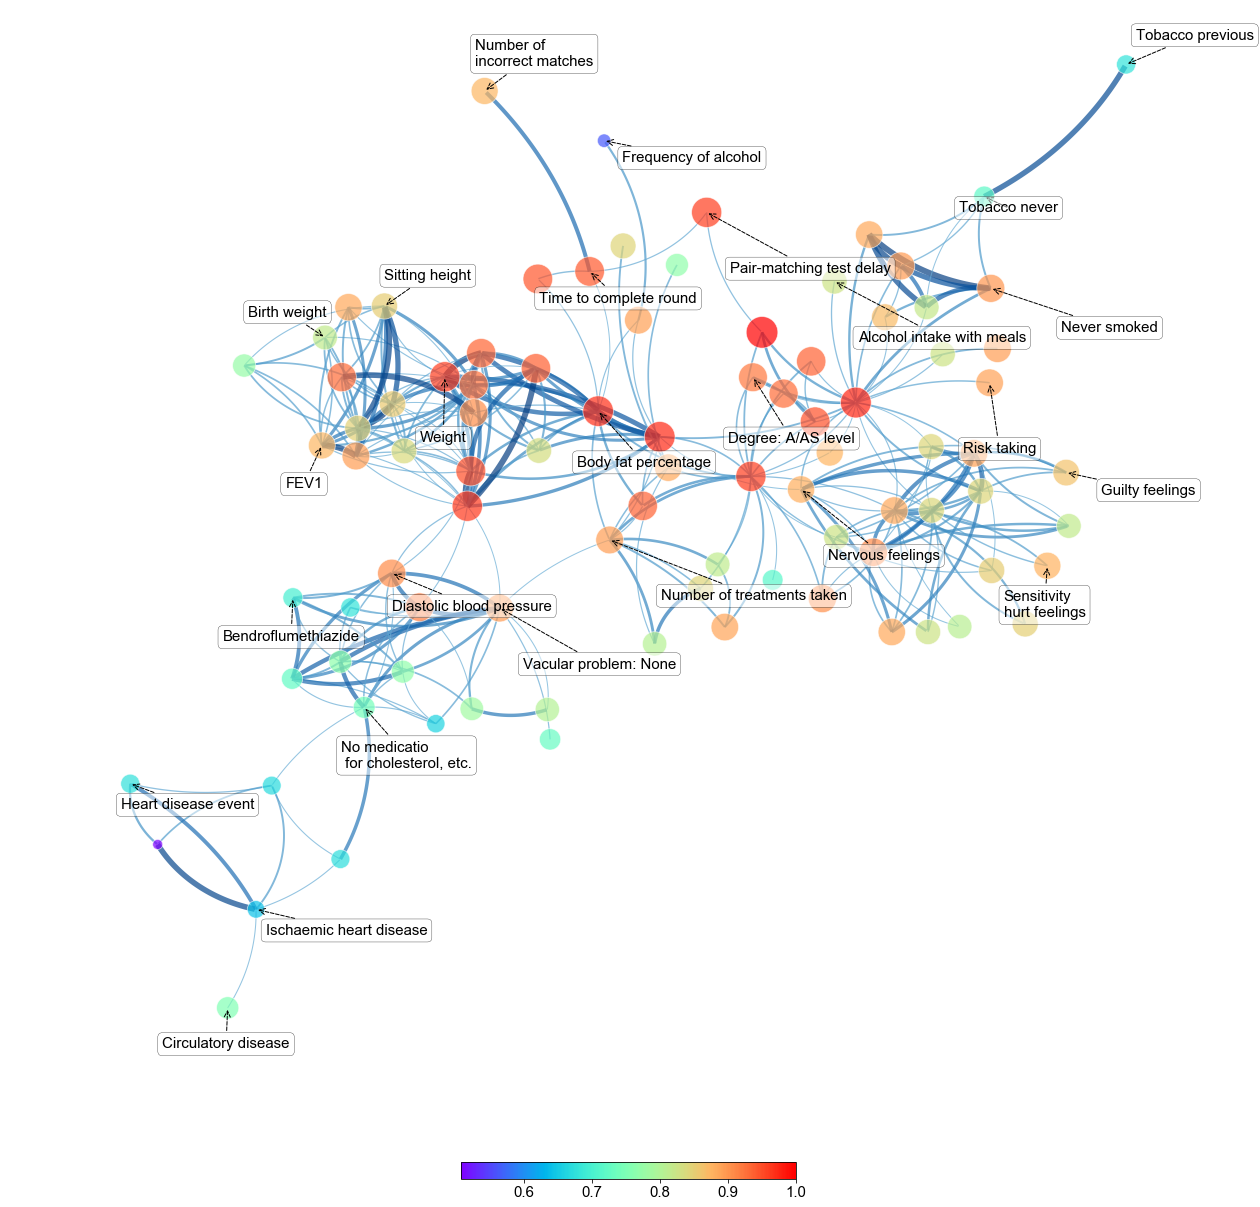

In [436]:
node_color='per_bp_var'
node_size='per_bp_var'
edge_width='value'
edge_color='value'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (20,25)
plt.rcParams["font.size"] = 15


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
        
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.rainbow)
        
plt.clf()

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths

line_collection_colors=np.array([plt.cm.Blues(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
sns.scatterplot(x=scatter_x,y=scatter_y,hue=scatter_hue,palette=plt.cm.rainbow,alpha=0.7,size=scatter_size,sizes=(100,1000),legend=None)#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    description_short=idx
    
    s=description_short
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

plt.show()



error
error
error


<Figure size 1440x1800 with 0 Axes>

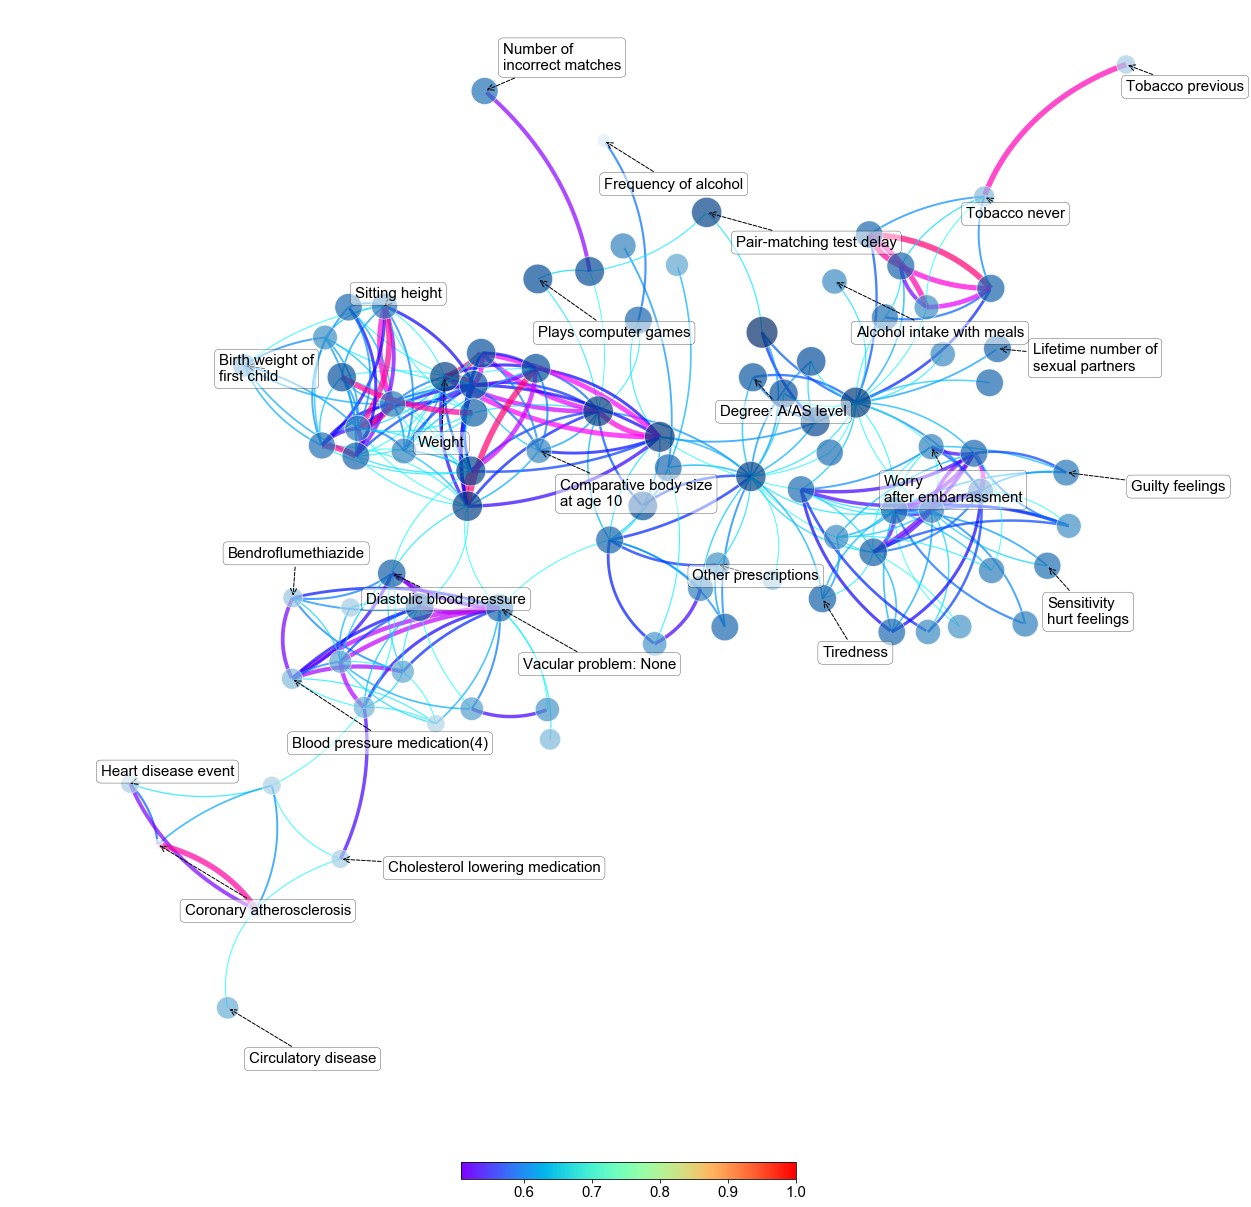

In [440]:
node_color='per_bp_var'
node_size='per_bp_var'
edge_width='value'
edge_color='value'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (20,25)
plt.rcParams["font.size"] = 15


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
        
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.rainbow)
        
plt.clf()

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths

line_collection_colors=np.array([plt.cm.hsv(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
sns.scatterplot(x=scatter_x,y=scatter_y,hue=scatter_hue,palette=plt.cm.Blues,alpha=0.7,size=scatter_size,sizes=(100,1000),legend=None)#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    description_short=idx
    
    s=description_short
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

plt.show()



In [437]:
line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths


In [438]:
line_collection_linewidths

array([1.21157823, 1.67785011, 2.73784304, 1.657081  , 2.04647142,
       1.39789978, 1.10491971, 2.38359523, 1.31888457, 1.1643797 ,
       1.10607669, 1.49550564, 1.97159831, 1.01994864, 2.77767577,
       1.08613431, 1.62346156, 1.6820664 , 1.50089835, 1.81953946,
       1.30020347, 1.89101509, 2.35662318, 1.05294272, 2.35854829,
       1.21712955, 1.17345928, 1.01821417, 2.74442017, 1.28822654,
       1.40954406, 1.00085088, 1.66145456, 2.00800625, 1.8985308 ,
       1.66220718, 1.31301324, 1.06387157, 1.79515404, 1.4358816 ,
       1.60346876, 1.49479678, 1.67792922, 1.85415451, 1.11668937,
       2.60400475, 1.26718935, 2.25453108, 1.31510008, 5.89228472,
       4.67786745, 5.13983043, 1.98369905, 5.64386111, 3.86018758,
       1.38251092, 5.46695286, 1.94105707, 1.02782234, 5.43058519,
       1.58057114, 2.0016007 , 1.64778067, 1.29566498, 2.66295013,
       1.01744618, 2.82797828, 1.55158056, 1.2511927 , 3.47995771,
       5.24059643, 1.81178155, 1.172094  , 1.82624086, 1.22336